In [1]:
import pandas as pd
from collections import Counter

df_cleaned = pd.read_csv('food_facts_clean_quantities.csv')
df_cleaned = df_cleaned.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [2]:
def possible_country(countries):
    return ("United States" == countries) or ("United Kingdom" == countries) \
            or ("Germany" == countries) or ("Spain" == countries)

In [3]:
df_countries = df_cleaned[df_cleaned.countries_en.apply(possible_country)]
numerical_features = ['additives_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition_score_fr_100g', 'quantity_num', 'liquid', 'solid']
df_countries_cleaned = pd.concat([df_countries, pd.get_dummies(df_countries.food_type).drop('unknown', axis=1)], axis=1)

In [4]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_countries_cleaned[numerical_features], df_countries_cleaned.countries_en, train_size=0.7)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

tuning_parameters = {"n_estimators": [100, 300], 'max_depth': [5, 10, 15]}
est = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1234)
rf = GridSearchCV(est, tuning_parameters, cv=5)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=1234, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_test_predict = rf.best_estimator_.predict(X_test)
confusion_matrix_results = confusion_matrix(y_test, y_test_predict)

In [7]:
import numpy as np

print "Error Rate over 4 Classes: {}".format(1 - 
    (float(np.diagonal(confusion_matrix_results).sum()) / confusion_matrix_results.sum()))
print "Precision: {}".format(precision_score(y_test, y_test_predict))
print "Recall:", recall_score(y_test, y_test_predict)
print "F1-score:", f1_score(y_test, y_test_predict)

Error Rate over 4 Classes: 0.23164556962
Precision: 0.765459212983
Recall: 0.76835443038
F1-score: 0.762063093728


C:\Users\Eugene\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Eugene\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_we

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_score = rf.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=['Germany', 'Spain', 'United Kingdom', 'United States'])

In [9]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

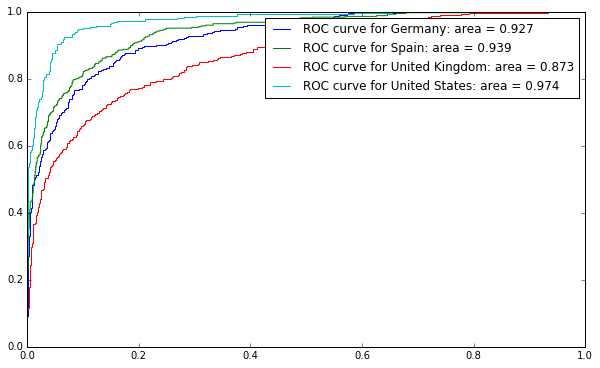

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
for i, country in zip(range(4), ['Germany', 'Spain', 'United Kingdom', 'United States']):
    plt.plot(fpr[i], tpr[i],
         label='ROC curve for {0}: area = {1:0.3f}'.format(country, roc_auc[i]))
plt.legend(loc=1)
plt.savefig('roc_plot.png')